In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
from hups_utilities import *
import numpy as np
from deepNeuralNetwork import *
from collections import OrderedDict
from collections import Counter
from dnn_app_utils_v2 import *

In [4]:
%matplotlib inline

class Game:
    players = []
    hands = []
    startingHands = []
    chipCap = 1000
    output = True
    outputDict = {'Text' : '', 'PlayerCards': {0: [], 1: []}, 'CommunityCards': [], 'Betting': []}
    
    bigBlind = 10
    smallBlind = bigBlind / 2
    button = 1
    pot = 0
    currentBet = 0
    deck = []
    community = []
    
    handType = {1: 'Straight Flush', 2: 'Quads', 3: 'Full House', 4: 'Flush', 5: 'Straight', 
                6: 'Trips', 7: 'Two Pair', 8: 'Pair', 9: 'High Card'}
    
    handsPlayed = 0.0
    straightFlushes, quads, fullHouses, flushes, straights, trips, twoPairs, pairs, highCards = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    preflopHandsWon = []
    preflopHandsPlayed = []
    preflopHandsPercentage = []

    def __init__(self, players, deck):
        self.players = players
        self.deck = deck
        self.testHands()
        self.resetStatisticalData()
        
    def printChips(self):
        for n in range(len(self.players)):
            print("Player " + str(n+1) + ": " + str(self.players[n].chips) + " chips.")
    
    def getHandTypeResults(self):
        handResults = [self.straightFlushes, self.quads, self.fullHouses, self.flushes, self.straights, 
                self.trips, self.twoPairs, self.pairs, self.highCards]
        return [handResults[x]/ (self.handsPlayed * 2) for x in range(len(handResults))]
    
    def getHandPercentages(self):
        preflopHandPercentage = [[self.preflopHandsWon[y][x]/self.preflopHandsPlayed[y][x] for x in range(13)] for y in range(13)]
        return preflopHandPercentage
    
    def testHands(self):
        deck = Deck()
        startingHands = []
        hands = []
        expectedResults = []
        
        testResults = 0
        
        #1.  Testing a straight flush with a higher straight and higher flush on board
        hands.append(deck.generateCards("askcqsjsts9s8s"))
        expectedResults.append(['Straight Flush', deck.generateCards("qsjsts9s8s")])
        
        #2.  Testing Quads with high card being part of a pair
        hands.append(deck.generateCards("asahadackskhqs"))
        expectedResults.append(['Quads', deck.generateCards("asahadacks")])
        
        #3.  Testing Full House with pair as part of another set
        hands.append(deck.generateCards("asahadkskhkdqs"))
        expectedResults.append(['Full House', deck.generateCards("asahadkskh")])
        
        #4.  Testing a 6 Flush with a straight to make sure that a straight flush isn't returned
        hands.append(deck.generateCards("qsjsth9s8s5s2s"))
        expectedResults.append(['Flush', deck.generateCards("qsjs9s8s5s")])
        
        #5.  Testing a 6 Straight with a pair and a 4 flush
        hands.append(deck.generateCards("jdtd9c9s8h7d6d"))
        expectedResults.append(['Straight', deck.generateCards("jdtd9c8h7d")])
        
        #6.  Testing trips with a 4 straight and 4 flush
        hands.append(deck.generateCards("jststhtd9s8s5d"))
        expectedResults.append(['Trips', deck.generateCards("tsthtdjs9s")])
        
        #7.  Testing two pair with high card sandwiched between them
        hands.append(deck.generateCards("qsqhjststd8s5h"))
        expectedResults.append(['Two Pair', deck.generateCards("qsqhtstdjs")])
        
        #8.  Testing one pair with two high cards below it
        hands.append(deck.generateCards("js9s9h8d7d6d4h"))
        expectedResults.append(['Pair', deck.generateCards("9s9hjs8d7d")])
        
        #9.  Testing only high cards with 4 straight and 4 flush
        hands.append(deck.generateCards("ksqsjsts8h7h6h"))
        expectedResults.append(['High Card', deck.generateCards("ksqsjsts8h")])
        
        #10. Testing a straight flush using the final card
        hands.append(deck.generateCards("asks9h8h7h6h5h"))
        expectedResults.append(['Straight Flush', deck.generateCards("9h8h7h6h5h")])
        
        #11. Testing quads using the final card
        hands.append(deck.generateCards("asksqs2s2h2d2c"))
        expectedResults.append(['Quads', deck.generateCards("2s2h2d2cas")])
        
        #12.Testing straight using the final card as a wheel
        hands.append(deck.generateCards("asksqs5h4h3h2h"))
        expectedResults.append(['Straight', deck.generateCards("5h4h3h2has")])
        
        #13. Testing straightflush with a wheel
        hands.append(deck.generateCards("ahksqs5h4h3h2h"))
        expectedResults.append(['Straight Flush', deck.generateCards("5h4h3h2hah")])
        
        #14. Testing wheel straight with a pair inside it
        hands.append(deck.generateCards("ah5s5c4c3s2h2s"))
        expectedResults.append(['Straight', deck.generateCards("5s4c3s2hah")])
        
        #15. Testing to make sure a 4-king wrap around doesn't register a straight
        hands.append(deck.generateCards("ahksthtc4c3h2s"))
        expectedResults.append(['Pair', deck.generateCards("thtcahks4c")])
        
        for x in range(len(hands)):
            #self.printOutput("Test Hand: " + str(x+1))
            hand = self.determineHand(hands[x])
            #self.printOutput([str(card) for card in hand[1]])
            #self.printOutput([str(card) for card in expectedResults[x][1]])
            result = (self.handType[hand[0]] == expectedResults[x][0] and hand[1] == expectedResults[x][1])
            if result:
                testResults += testResults
            else:
                print "Error on test: " + str(x+1)
                print "We started with: " + str([str(hands[x][y]) for y in range(len(hands[x]))])
                print "Expected a " + expectedResults[x][0] + " with: " + str([str(expectedResults[x][1][y]) for y in range(len(expectedResults[x][1]))])
                print "We got a " + self.handType[hand[0]] + " with: " + str([str(hand[1][y]) for y in range(len(hand[1]))])
                
    def printOutput(self, output):
        self.outputDict['Text'] += str(output) + "\n"
        if self.output :
            print output

    def printCards(self, cards):
        print [str(cards[x]) for x in range(len(cards))]
    
    def sortHands(self):
        self.printOutput("\nSorting Hands")
        for x in range(len(self.players)):
            self.hands[x] = self.hands[x] + self.community
            self.hands[x] = sorted(self.hands[x], reverse=True)

    def countSuits(self, hand):
        flushCount = [0] * 4
        flushSuit = ""
        maxSuit = 0
        for y in range(len(deck.suit)):
            for x in range(len(hand)):
                if hand[x].suit == deck.suit[y]:
                    flushCount[y] += 1
            if flushCount[y] > maxSuit:
                maxSuit = flushCount[y]
                flushSuit = deck.suit[y]
        return [flushSuit, maxSuit]
    
    def determineHand(self, hand): 
        
        hasPair, hasTrips, hasQuads, hasStraight, hasWheel, hasFlush, hasStraightFlush = [False]*7
        bestHand, flush, high, pairs, trips, quads, straight = [], [], [], [], [], [], []
        
        temp = self.countSuits(hand)
        flushSuit = temp[0]
        flushCount = temp[1]
        delta = [None] * (len(hand))
        pairCount = 1
        straightCount = 0
        
        if flushCount >= 5:
            hasFlush = True
            for card in hand:
                if card.suit == flushSuit:
                    flush.append(card)
        
        #Adding a buffer to the end of the hand so I can check card rank differences and for the wheel
        hand.append(hand[0])
        
        for x in range(len(hand)-1):
            delta[x]= hand[x].value - hand[x+1].value
            if delta[x] == 0:
                pairCount+=1
            else:
                if pairCount > 1:
                    if pairCount == 2: 
                        pairs.extend(hand[x-1: x+1])
                        hasPair = True
                    if pairCount == 3: 
                        trips.extend(hand[x-2: x+1])
                        hasTrips = True
                    if pairCount == 4: 
                        quads.extend(hand[x-3:x+1])
                        hasQuads = True
                    pairCount = 1
                if (delta[x] % 13) == 1:
                    straightCount += 1
                    if straightCount == 4: 
                        straightEnd = hand[x+1]
                        hasStraight = True
                        if straightEnd.value == 14: 
                            hasWheel == True
                else: straightCount = 0   
                    
        #self.printOutput(delta[:-1])
        if hasFlush and hasStraight:
            flush.append(flush[0])
            straightFlushCount = 1
            for x in range(len(flush)-1):
                if (flush[x].value - flush[x+1].value) % 13 == 1:
                    straightFlushCount += 1
                    if straightFlushCount == 5:
                        bestHand = flush[x-3:x+2]
                        hasStraightFlush = True
                else:
                    straightFlushCount = 1
                #if x == len(flush)-2:
        
        #This is purely for collecting data and making sure that each type of hand is occuring the right % of the time
        if hasStraightFlush: self.straightFlushes += 1
        elif hasQuads: self.quads += 1
        elif hasPair and hasTrips: self.fullHouses += 1
        elif hasFlush: self.flushes += 1
        elif hasStraight: self.straights += 1
        elif hasTrips: self.trips += 1
        elif hasPair:
            if len(pairs) > 2: self.twoPairs +=1
            else: self.pairs += 1
        
        if hasStraightFlush: bestHand = [1, bestHand]
        elif hasQuads: bestHand = [2, quads + sorted(list((set(hand) - set(quads))), reverse=True)[:1]]
        elif hasTrips and hasPair: bestHand = [3, trips[:3] + pairs[:2]]
        elif len(trips) > 3: bestHand = [3, trips[:5]]
        elif hasFlush: bestHand = [4, flush[:5]]
        elif hasStraight:
            bestHand = []
            endValue = straightEnd.value
            if endValue == 14: 
                hasWheel = True
                endValue = 1
            for x in range(4, -1, -1):
                for card in hand:
                    if card.value == endValue + x:
                        bestHand.append(card)
                        break
            if hasWheel: bestHand.append(hand[0])
            bestHand = [5, bestHand]
        elif hasTrips: bestHand = [6, trips[:3] + sorted(list((set(hand) - set(trips))), reverse=True)[:2]]
        elif hasPair and len(pairs) > 2: bestHand = [7, pairs[:4] + sorted(list((set(hand) - set(pairs))), reverse=True)[:1]]
        elif hasPair: bestHand = [8, pairs[:2] + sorted(list((set(hand) - set(pairs))), reverse=True)[:3]]
        else:
            self.highCards += 1
            bestHand = [9, hand[:5]]
        return bestHand
    
    def postBlinds(self):
        self.players[self.button].chips -= self.smallBlind
        self.players[(self.button + 1)%2].chips -= self.bigBlind
        self.pot = self.bigBlind + self.smallBlind
        self.currentBet = self.bigBlind - self.smallBlind
        
        self.printOutput("Player " + str(self.button + 1) + " posts " + str(self.smallBlind) + " chips")
        self.printOutput("Player " + str((self.button + 1) % 2 + 1) + " posts " + str(self.bigBlind) + " chips")
        self.printOutput("Pot: " + str(self.pot))
        
    def playerWinsChips(self, player):
        self.printOutput("\nPlayer " + str(player+1) + " Wins " + str(self.pot) + " chips\n")
        self.players[player].chips += self.pot
        self.pot = 0
        
        for i in range(len(self.players)):
            self.printOutput("Player " + str(i+1) + ": " + str(self.players[i].chips) + " chips")
        
    def playerWins(self, player):
        self.playerWinsChips(player)
        
        for x in range(2):
            self.preflopHandsPlayed[14-self.startingHands[x][0].value][14-self.startingHands[x][1].value] += 1
        self.preflopHandsWon[14-self.startingHands[player][0].value][14-self.startingHands[player][1].value] += 1
        
        #The preflop starting matrix stores unsuited hands below the diagonal for readability
        
    def draw(self):
        self.printOutput("It's a Draw!")
        for x in range(len(self.players)):
            self.players[x].chips += self.pot/2
        self.pot = 0
        for x in range(2):
            self.preflopHandsPlayed[14-self.startingHands[x][0].value][14-self.startingHands[x][1].value] += 1
            self.preflopHandsWon[14-self.startingHands[x][0].value][14-self.startingHands[x][1].value] += .5
    
    def clearHandData(self):
        self.hands = []
        self.startingHands = []
        self.community = []
        
    def resetStatisticalData(self):
        self.handsPlayed = 0
        self.preflopHandsWon = []
        self.preflopHandsPlayed = []
        for x in range(13):
            self.preflopHandsWon.append([])
            self.preflopHandsPlayed.append([])
            for y in range(13):
                self.preflopHandsWon[x].append(1.0)
                self.preflopHandsPlayed[x].append(2.0)

        
    def newHandCleanup(self):
        self.outputDict = {'Text' : '', 'PlayerCards': {0: [], 1: []}, 'CommunityCards': [], 'Betting': []}
        self.button = (self.button + 1) % 2
        self.betAmount = 0
        self.pot = 0
        self.postBlinds()
        self.clearHandData()
        self.deck.shuffle()
        self.handsPlayed += 1
        for x in self.players:
            x.newHand()
        
    def nextHand(self):
        self.newHandCleanup()
        for x in range(len(self.players)):
            cards = self.deck.deal(2)
            cards = sorted(cards, reverse= True)
            self.hands.append(cards)
            self.players[x].hand = cards
            cards = sorted(cards, reverse= (cards[0].suit == cards[1].suit))
            self.startingHands.append(cards)

        self.printOutput("")
            
        for x in range(len(self.hands)):
            self.printOutput('Player ' + str((x + 1)) + ": " + str([str(self.hands[x][0]), str(self.hands[x][1])]))
        
        self.betOpportunity(self.button, None)
        #if 'Fold' in self.outputDict['Betting']: return
        self.printOutput("Pot: " + str(self.pot))

        self.community = self.deck.deal(3)
        #self.printOutput("Flop: ")
        #self.printOutput([str(self.community[x]) for x in range(3)])
        
        self.community = self.community + self.deck.deal(1)
        #self.printOutput("Turn: ")
        #self.printOutput([str(self.community[x]) for x in range(4)])
        
        self.community = self.community + self.deck.deal(1)
        self.printOutput('\nRiver: ')
        self.printOutput([str(self.community[x]) for x in range(5)])
        
        '''display(community[0].image, community[1].image)'''
        self.sortHands()
    
        for x in range(len(self.hands)):
            self.hands[x] = self.determineHand(self.hands[x])
            self.printOutput("Player " + str(x+1) + " has " + self.handType[self.hands[x][0]] + ": " + str([str(card) for card in self.hands[x][1]]))

            
        if self.hands[0][0] < self.hands[1][0]:
            self.playerWins(0)
        elif self.hands[0][0] > self.hands[1][0]:
            self.playerWins(1)
        else:
            for x in range(len(self.hands[0][1])):
                if self.hands[0][1][x] > self.hands[1][1][x]:
                    self.playerWins(0)
                    break;
                elif self.hands[0][1][x] < self.hands[1][1][x]:
                    self.playerWins(1)
                    break;
                elif x == len(self.hands[0][1]) - 1:
                    self.draw()
        
        self.printOutput("----------------------------------------------------------------\n")
        
        
    #TODO
    def betOpportunity(self, playerNumber, previousAction = None):
        action = self.players[playerNumber].decide(previousAction, self.currentBet)
        self.outputDict['Betting'].append(action)
        otherPlayerNumber = (playerNumber+1)%2
        if action == "Fold":
            self.printOutput("Player " + str(playerNumber + 1) + " Folds")
            self.playerWinsChips(otherPlayerNumber)   
        elif action == "Raise" or action == 'Bet':
            self.printOutput("Player " + str(playerNumber + 1) + " " + action + "s " + str(self.pot + self.currentBet) + " chips")
            self.players[playerNumber].chips -= self.currentBet
            self.pot += self.currentBet
            
            self.currentBet = self.pot
            self.pot += self.currentBet
            self.players[playerNumber].chips -= self.currentBet
            
            self.betOpportunity(otherPlayerNumber, action)
        elif action == "Check":
            self.printOutput("Player " + str(playerNumber + 1) + " Checks")
            if previousAction == None:
                self.betOpportunity(otherPlayerNumber, action)
        elif action == "Call":
            self.printOutput("Player " + str(playerNumber + 1) + " Calls " + str(self.currentBet) + " chips")
            self.players[playerNumber].chips -= self.currentBet
            self.pot += self.currentBet
            self.currentBet = 0
            if previousAction == None:
                self.betOpportunity(otherPlayerNumber, action)
                
deck = Deck()
Player1 = Player(True, 2)
Player2 = Player(True, 3)
game = Game([Player1,Player2], deck)
game.output = False
hands = 10009
for x in range(hands):
    game.nextHand()

print Player2.preflopHandOdds


OrderedDict([('AAo', 0.569177956727), ('QQo', 0.569177956727), ('JJo', 0.569177956727), ('TTo', 0.569177956727), ('99o', 0.569177956727), ('88o', 0.569177956727), ('K6o', 0.569177956727), ('66o', 0.569177956727), ('A5o', 0.569177956727), ('K5o', 0.569177956727), ('KKo', 0.569174266064), ('AQo', 0.566200134435), ('QTo', 0.56486637142), ('A8o', 0.564617969099), ('AKs', 0.557405282939), ('AQs', 0.557245117163), ('KTs', 0.556339941636), ('AJo', 0.55548610142), ('KQo', 0.555054700084), ('KQs', 0.554906700245), ('A4o', 0.553487688396), ('A2o', 0.550335971173), ('A5s', 0.546739509616), ('K4o', 0.546244769385), ('A6o', 0.544274867184), ('Q9s', 0.543714690995), ('AKo', 0.54342220204), ('A7o', 0.543093116179), ('AJs', 0.542098949415), ('Q8o', 0.541906102245), ('K2o', 0.539146634859), ('KJs', 0.53824811736), ('A9s', 0.537721898019), ('77o', 0.537369944141), ('K9s', 0.536929457812), ('A6s', 0.533754458964), ('A4s', 0.53228244198), ('A3s', 0.531217580797), ('A2s', 0.531217580797), ('KTo', 0.5303188

0 0.100721528395 0.10392991557
250 0.0951615212139 0.167744899509
500 0.094515527762 0.161931393053
750 0.0899384423377 0.140116124302
1000 0.0878534090295 0.129634326712
1250 0.0842718989222 0.121916228034
1500 0.0841457752512 0.117731649756
1750 0.0798931543687 0.105267123049
2000 0.0741176256984 0.0951576636003
2250 0.0714243031138 0.0909942578932
2500 0.071079162674 0.0920873127635
2750 0.0721296231473 0.0915603134106
3000 0.0681747091038 0.0864044380919
3250 0.0680227286236 0.0857194331571
3500 0.0673630521143 0.0847776461007
3750 0.0669556535016 0.082628422427
4000 0.0654597437506 0.0803362354575
4250 0.0644950715104 0.0785696850605
4500 0.0628150761069 0.0760571004086
4750 0.0633244560964 0.0747773908214


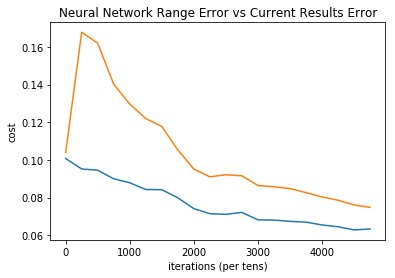

In [3]:
class Player:
    isAI = True
    AIlevel = 1
    chips = 0
    bankroll = 999000
    hands = 0
    hand = []
    preflopHandOdds = []
    currentRange = []
    decisions = ['Fold', 'Call', 'Check', 'Bet', 'Raise']
    aiType = {1 : 'Calling Station', 2 : 'GTO', 3 : 'NeuralGTO'}
    
    def __init__(self, isAI = True, AIlevel = 1):
        self.isAI = isAI
        self.AIlevel = AIlevel
        if isAI:
            self.preflopHandOdds = OrderedDict(createPreflopOrderedRange(np.loadtxt("data", unpack=True)))
            if AIlevel in [2, 3]:
                self.updateHandRange()
            
    def newHand(self):
        self.hands += 1
        if self.hands % 10000 == 0:
            self.updateHandRange()
        self.currentRange = self.preflopHandOdds
    
    def generateHandAbbreviation(self):
        suited = 'o'
        if self.hand[0].suit == self.hand[1].suit:
            suited = 's'
        return self.hand[0].rank + self.hand[1].rank + suited
    
    def decideLevel1(self, previousAction, raiseAmount = 0):
        if previousAction == None:
            if raiseAmount > 0: return 'Call'
            else: return 'Check'
        elif previousAction == 'Bet' or previousAction == 'Raise': return 'Call'
        elif previousAction == 'Call' or previousAction == 'Check': return 'Check'
        
            
    def decideLevel2(self, previousAction, raiseAmount = 0):
        n = len(self.currentRange)
        odds = self.currentRange[self.generateHandAbbreviation()]
        
        if previousAction in ['Call', 'Check', None]:
            if odds > self.currentRange.values()[n//3]: 
                self.currentRange = OrderedDict(self.currentRange.items()[:n//3])
                return 'Bet'
            elif raiseAmount > 0: return 'Call' 
            else: return 'Check'
        elif previousAction == 'Bet' or previousAction == 'Raise':
            if odds > self.currentRange.values()[(2*n)//9]: 
                self.currentRange = OrderedDict(self.currentRange.items()[:(2*n)//9])
                return 'Raise'
            elif odds > self.currentRange.values()[(2*n)//3]:
                self.currentRange = OrderedDict(self.currentRange.items()[:(2*n)//3])
                return 'Call'
            else:
                return 'Fold'
        assert False
    
    def updateHandRange(self):
        if self.AIlevel == 3:
            currentHandPercentages = np.array(game.getHandPercentages()).reshape(1,169)
            overallHandPercentages = np.loadtxt("data", unpack=True).reshape(1, 169)

            train_x = currentHandPercentages
            train_y = overallHandPercentages

            n_x = train_x.shape[0]
            n_y = train_y.shape[0]
            layers_dims = [n_x, 50, 12, 5, n_y] #  This determines how many hidden layers the network will use

            parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = .2, num_iterations = 1000, print_cost = False, plotGraph = False)

            AL, caches = L_model_forward(currentHandPercentages, parameters)
            
            self.preflopHandOdds = OrderedDict(createPreflopOrderedRange(AL.reshape(13, 13)))
    
    def decide(self, previousAction, raiseAmount = 0):
        if self.isAI:
            if self.AIlevel == 1: return self.decideLevel1(previousAction, raiseAmount)
            elif self.AIlevel in [2,3]: return self.decideLevel2(previousAction, raiseAmount)
            

deck = Deck()
Player1 = Player(True, 1)
Player2 = Player(True, 1)
game = Game([Player1,Player2], deck)
game.output = False
hands = 5000
neuralCosts = []
currentCosts = []
iterations = []
for x in range(hands):
    game.nextHand()
    if x % (hands/20) == 0:
        currentHandPercentages = np.array(game.getHandPercentages()).reshape(1,169)
        overallHandPercentages = np.loadtxt("data", unpack=True).reshape(1, 169)
        
        train_x = currentHandPercentages
        train_y = overallHandPercentages
        
        n_x = train_x.shape[0]
        n_y = train_y.shape[0]
        layers_dims = [n_x, 50, 12, 5, n_y] #  This determines how many hidden layers the network will use
        
        parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = .5, num_iterations = 1000, print_cost = False, plotGraph = False)

        AL, caches = L_model_forward(currentHandPercentages, parameters)
        
        neuralCost = compute_cost(AL, overallHandPercentages)
        currentCost = compute_cost(currentHandPercentages, overallHandPercentages)
        
        neuralCosts.append(neuralCost)
        currentCosts.append(currentCost)
        iterations.append(x)
        
        print x, neuralCost, currentCost


        
plt.plot(iterations, neuralCosts)
plt.plot(iterations, currentCosts)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Neural Network Range Error vs Current Results Error")
plt.show()
    #if game.outputDict['Betting'].count('Raise') > 2:
        #print game.outputDict['Text']
        #break;
        


In [5]:
def printStartingHandPercentages(number):
    hands = number
    game.output = False
    for x in range(hands):
        game.nextHand()
    # This is for saving the data, but since running 10,000,000 hands took a few hours, I'm happy to stick with the results I have
    '''
    f = open("data", "w")
    np.savetxt(f, np.array([float(x) for x in np.array(startingHands).reshape(169,)]).reshape(13,13), fmt="%.3f", header="starting hands")
    f.close()
    hands = np.loadtxt("data", unpack=True)
    '''
    print "After " + str(game.handsPlayed) + " hands..."
    #print ['{:02.4f}'.format(game.getHandTypeResults()[x] * 100) for x in range(9)]

    print "      " + str(["  " + deck.rank[y] + "  " for y in range(13)])
    for y in range(13):
        #print ['{:04.2f}'.format(game.preflopHandsPlayed[y][x] * (1326 / 2)  / game.handsPlayed).zfill(5) for x in range(13)]
        print str([deck.rank[y]]) + " " + str(['{:03.3f}'.format(game.getHandPercentages()[y][x]) for x in range(13)])

In [47]:
pokerHands, results, n1, n2 = generateStartingHands(game.getHandPercentages(), False)
#pokerHands.T

In [9]:
currentHandPercentages = np.array(game.getHandPercentages()).reshape(1,169)
overallHandPercentages = np.loadtxt("data", unpack=True).reshape(1, 169)
compute_cost(currentHandPercentages, overallHandPercentages)

0.10124137774668683

In [45]:
print "Hello World"

Hello World


In [43]:
np.loadtxt("data", unpack=True).reshape(1, 169)

array([[ 0.854,  0.655,  0.642,  0.635,  0.628,  0.608,  0.596,  0.589,
         0.574,  0.576,  0.567,  0.558,  0.549,  0.668,  0.824,  0.615,
         0.606,  0.598,  0.577,  0.562,  0.552,  0.542,  0.535,  0.524,
         0.513,  0.504,  0.661,  0.637,  0.799,  0.582,  0.573,  0.553,
         0.535,  0.519,  0.507,  0.501,  0.493,  0.482,  0.474,  0.655,
         0.63 ,  0.599,  0.775,  0.55 ,  0.532,  0.514,  0.498,  0.478,
         0.47 ,  0.463,  0.454,  0.444,  0.646,  0.622,  0.595,  0.575,
         0.748,  0.513,  0.499,  0.478,  0.462,  0.441,  0.434,  0.429,
         0.417,  0.63 ,  0.603,  0.578,  0.556,  0.54 ,  0.719,  0.48 ,
         0.465,  0.446,  0.426,  0.404,  0.401,  0.391,  0.617,  0.582,
         0.56 ,  0.539,  0.522,  0.509,  0.688,  0.45 ,  0.429,  0.414,
         0.394,  0.375,  0.369,  0.612,  0.576,  0.543,  0.52 ,  0.51 ,
         0.492,  0.479,  0.662,  0.424,  0.406,  0.385,  0.366,  0.347,
         0.602,  0.567,  0.531,  0.509,  0.491,  0.477,  0.464, 

In [46]:
testPokerStartingHands()

Number of training examples: 152
train_x_orig shape: (4L, 152L)
train_y shape: (1L, 152L)
Tests Comleted
Cost after iteration 0: 0.086618
Cost after iteration 100: 0.076472
Cost after iteration 200: 0.070838
Cost after iteration 300: 0.067018
Cost after iteration 400: 0.064027
Cost after iteration 500: 0.061462
Cost after iteration 600: 0.059168
Cost after iteration 700: 0.057037
Cost after iteration 800: 0.054922
Cost after iteration 900: 0.052735
Cost after iteration 1000: 0.050665
Cost after iteration 1100: 0.048728
Cost after iteration 1200: 0.046953
Cost after iteration 1300: 0.045271
Cost after iteration 1400: 0.043676
Cost after iteration 1500: 0.042182
Cost after iteration 1600: 0.040775
Cost after iteration 1700: 0.039503
Cost after iteration 1800: 0.038294
Cost after iteration 1900: 0.037220
Cost after iteration 2000: 0.036157
Cost after iteration 2100: 0.035089
Cost after iteration 2200: 0.034038
Cost after iteration 2300: 0.032957
Cost after iteration 2400: 0.031922
Trainin

In [7]:
3 in [2,3]

True